In [73]:
!pip3 install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [74]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

In [75]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [76]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
# The params latitude and longitude are for NW France
params = {
    "latitude": 46.22,
    "longitude": 2.21,
    "hourly": ["temperature_2m", "dew_point_2m", "apparent_temperature", "precipitation_probability", "precipitation", "rain", "showers", "snowfall", "snow_depth"]
}
responses = openmeteo.weather_api(url, params=params)

In [77]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 46.220001220703125°E 2.2199997901916504°N
Elevation 391.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [78]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
hourly_rain = hourly.Variables(5).ValuesAsNumpy()
hourly_showers = hourly.Variables(6).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(7).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(8).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s"),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation_probability"] = hourly_precipitation_probability
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["showers"] = hourly_showers
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth

hourly_dataframe = pd.DataFrame(data = hourly_data)



In [79]:
hourly_dataframe

,date,temperature_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth
0,2023-11-28 00:00:00,7.559,5.698797,2.987986,100.0,0.1,0.0,0.1,0.0,0.0
1,2023-11-28 01:00:00,7.159,5.304710,2.372013,99.0,0.1,0.1,0.0,0.0,0.0
2,2023-11-28 02:00:00,7.109,5.091071,2.139391,98.0,0.3,0.2,0.0,0.0,0.0
3,2023-11-28 03:00:00,6.959,5.270201,2.172543,97.0,0.1,0.1,0.0,0.0,0.0
4,2023-11-28 04:00:00,6.509,4.500700,1.711694,93.0,0.7,0.6,0.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
163,2023-12-04 19:00:00,0.373,-2.844382,-2.889452,19.0,0.2,0.2,0.0,0.0,0.0
164,2023-12-04 20:00:00,0.523,-2.698322,-2.771255,19.0,0.2,0.2,0.0,0.0,0.0
165,2023-12-04 21:00:00,0.623,-2.600950,-2.660353,19.0,0.2,0.2,0.0,0.0,0.0
166,2023-12-04 22:00:00,0.573,-2.145774,-2.545518,19.0,0.3,0.3,0.0,0.0,0.0


In [80]:
# Working on a basic Linear Regression model
# Temperature vs pericitation 
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [81]:
X = hourly_dataframe[['precipitation']]
X.columns = ['precipitation']

y = hourly_dataframe['temperature_2m']

In [82]:
model= LinearRegression()

In [83]:
model.fit(X,y)

LinearRegression()

In [84]:
y_pred = model.predict(X)


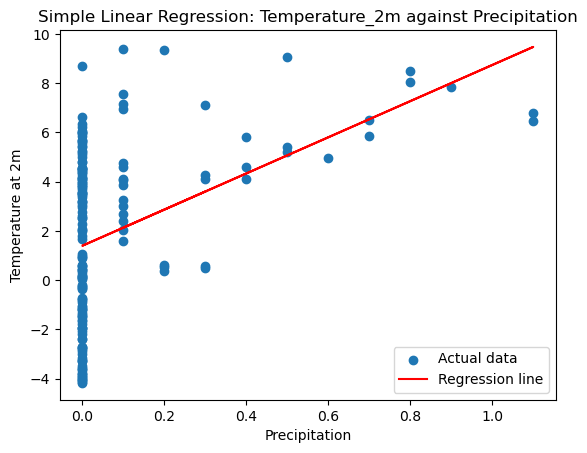

In [85]:
# Plot the data and the regression line
plt.scatter(X, y, label='Actual data')
plt.plot(X, y_pred, color='red', label='Regression line')
plt.xlabel('Precipitation')
plt.ylabel('Temperature at 2m')
plt.title('Simple Linear Regression: Temperature_2m against Precipitation')
plt.legend()
plt.show()

In [86]:
# Print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient): {model.coef_[0]}")


Slope (Coefficient): 7.345149040222168


In [87]:
# Replace this value with the precipitation value for which you want to make a prediction
new_precipitation_value = 0.56

# Reshape the input to a 2D array as the model expects
new_precipitation_value_reshaped = np.array([[new_precipitation_value]])

# Make a prediction for the new precipitation value
predicted_temperature = model.predict(new_precipitation_value_reshaped)

print(f"For precipitation = {new_precipitation_value}, predicted temperature at 2m is {predicted_temperature[0]:.2f} degrees.")


For precipitation = 0.56, predicted temperature at 2m is 5.51 degrees.


/Users/ritwikgoel/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [88]:
#For Polynimal Regression:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [89]:
# Extract the relevant columns
X = hourly_dataframe[['precipitation']]
y = hourly_dataframe['temperature_2m']



In [90]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose the degree of the polynomial (you can adjust this)
degree = 2



In [91]:
# Create polynomial features
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)



In [92]:
# Create and fit the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)



LinearRegression()

In [93]:
# Make predictions on the test set
y_pred = model.predict(X_test_poly)



In [94]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 9.932417869567871


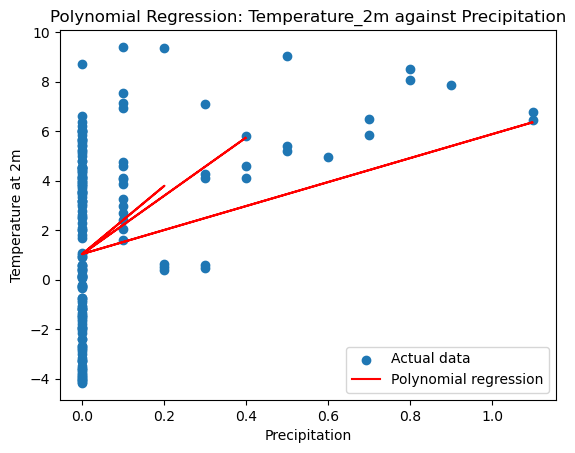

In [95]:
# Plot the results
plt.scatter(X, y, label='Actual data')
plt.plot(X_test, y_pred, color='red', label='Polynomial regression')
plt.xlabel('Precipitation')
plt.ylabel('Temperature at 2m')
plt.title('Polynomial Regression: Temperature_2m against Precipitation')
plt.legend()
plt.show()


In [96]:
# Replace this value with the precipitation value for which you want to make a prediction
new_precipitation_value = 0.5

# Create a polynomial feature for the new precipitation value
new_precipitation_value_poly = poly.transform(np.array([[new_precipitation_value]]))

# Make a prediction for the new precipitation value
predicted_temperature = model.predict(new_precipitation_value_poly)

print(f"For precipitation = {new_precipitation_value}, predicted temperature at 2m is {predicted_temperature[0]:.2f} degrees.")


For precipitation = 0.5, predicted temperature at 2m is 6.43 degrees.


/Users/ritwikgoel/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [97]:
#Now for Decision trees:-> POssibly overfitting

In [98]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt




In [99]:


# Extract the relevant columns
X = hourly_dataframe[['precipitation']]
y = hourly_dataframe['temperature_2m']



In [100]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [101]:
# Create and fit the Decision Tree regression model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)



DecisionTreeRegressor(random_state=42)

In [102]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [103]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 10.219834827748329


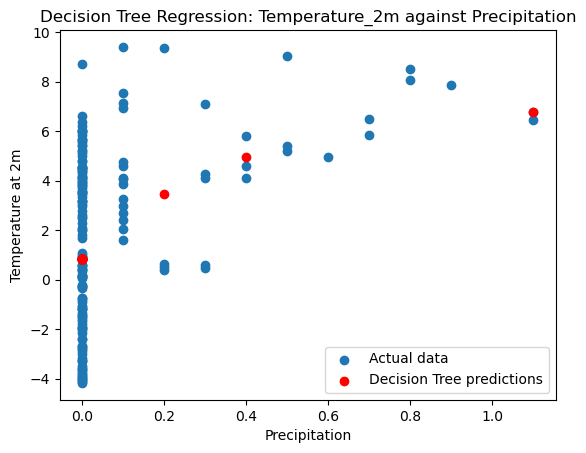

In [104]:

# Plot the results
plt.scatter(X, y, label='Actual data')
plt.scatter(X_test, y_pred, color='red', label='Decision Tree predictions')
plt.xlabel('Precipitation')
plt.ylabel('Temperature at 2m')
plt.title('Decision Tree Regression: Temperature_2m against Precipitation')
plt.legend()
plt.show()

In [105]:
# Replace this value with the precipitation value for which you want to make a prediction
new_precipitation_value = 0.4

# Create a NumPy array with the new precipitation value
new_precipitation_value_array = np.array([[new_precipitation_value]])

# Make a prediction for the new precipitation value
predicted_temperature = model.predict(new_precipitation_value_array)

print(f"For precipitation = {new_precipitation_value}, predicted temperature at 2m is {predicted_temperature[0]:.2f} degrees.")


For precipitation = 0.4, predicted temperature at 2m is 4.96 degrees.


/Users/ritwikgoel/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [106]:
#Checking for overfitting
from sklearn.metrics import mean_squared_error

# Assuming you have a model named 'model' and datasets X_train, y_train, X_test, y_test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {mse_train}')
print(f'Testing MSE: {mse_test}')
#If the error on the testing dataset is significantly higher 
#than the training error, it could indicate overfitting.
# It is not significantly Higher so there is no overfitting

Training MSE: 9.380921280102523
Testing MSE: 10.219834827748329


In [108]:
# For MLP Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [109]:
# Extract the relevant columns
X = hourly_dataframe[['precipitation']]
y = hourly_dataframe['temperature_2m']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [110]:
# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [127]:
model = MLPRegressor(
    hidden_layer_sizes=(20, 15),
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,  # Fraction of training data to use as validation set
    random_state=42
)


In [128]:
# Fit the model to the scaled training data
model.fit(X_train_scaled, y_train)



MLPRegressor(early_stopping=True, hidden_layer_sizes=(20, 15), max_iter=500,
             random_state=42)

In [129]:
# Make predictions on the scaled test set
y_pred = model.predict(X_test_scaled)



In [130]:

# Inverse transform the predictions to the original scale
y_pred_original_scale = scaler.inverse_transform(y_pred.reshape(-1, 1))



In [131]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_original_scale)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 12.34925365447998


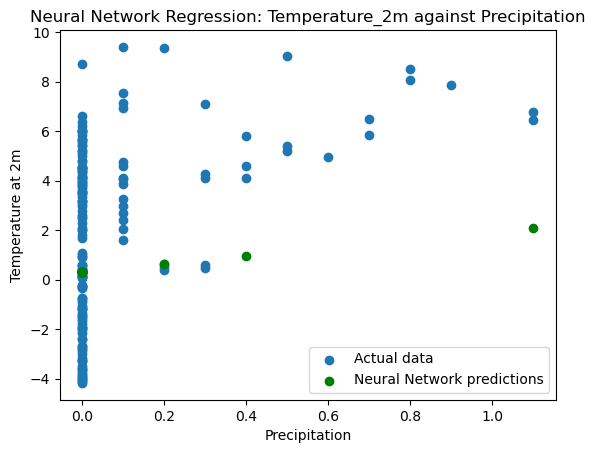

In [132]:
# Plot the results
plt.scatter(X, y, label='Actual data')
plt.scatter(X_test, y_pred_original_scale, color='green', label='Neural Network predictions')
plt.xlabel('Precipitation')
plt.ylabel('Temperature at 2m')
plt.title('Neural Network Regression: Temperature_2m against Precipitation')
plt.legend()
plt.show()

In [133]:
# Replace this value with the precipitation value for which you want to make a prediction
new_precipitation_value = 0.8

# Create a NumPy array with the new precipitation value
new_data = np.array([[new_precipitation_value]])

# Standardize the input features using the same scaler used during training
new_data_scaled = scaler.transform(new_data)

# Make a prediction for the new data
predicted_temperature_scaled = model.predict(new_data_scaled)

# Inverse transform the predicted temperature to the original scale
predicted_temperature_original_scale = scaler.inverse_transform(predicted_temperature_scaled.reshape(-1, 1))

print(f"For precipitation = {new_precipitation_value}, predicted temperature at 2m is {predicted_temperature_original_scale[0][0]:.2f} degrees.")


For precipitation = 0.8, predicted temperature at 2m is 1.59 degrees.


/Users/ritwikgoel/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [134]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_original_scale)
print(f'Mean Absolute Error: {mae}')

# Evaluate the model using R-squared
r2 = r2_score(y_test, y_pred_original_scale)
print(f'R-squared: {r2}')


Mean Absolute Error: 2.899794816970825
R-squared: -0.3065896515975228
